# Only for the reviewers of 2024 ECCV #6858 paper
- This notebook contains Decorruptor-DPM version for corrouption editing

In [1]:
import os
import random
import torch 
import numpy as np
from glob import glob 
from diffusers im   port DDIMScheduler, AutoencoderKL, UNet2DConditionModel
from natsort import natsorted 
from pipeline.deccoruptor_dpm_pipe import ConsistInstructPix2PixPipeline
from transformers import CLIPTokenizer, CLIPTextModel, CLIPImageProcessor
from PIL import Image, ImageOps
import torchvision
import torchvision.transforms as transforms

%load_ext autoreload
%autoreload 2

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "8"  
device = "cuda:0"

model_id = "Anonymous-12/DeCorruptor-DPM" 
pipe = ConsistInstructPix2PixPipeline.from_pretrained(model_id,
                                            torch_dtype=torch.float16, 
                                            use_safetensors=True, 
                                            safety_checker=None)
pipe.to(device)

2024-03-07 22:14:15.906589: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-07 22:14:15.945787: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 22:14:15.945831: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 22:14:15.945851: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 22:14:15.953648: I tensorflow/core/platform/cpu_feature_g

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/home/dsailyt/anaconda3/envs/MVdream/lib/python3.9/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
You have disabled the safety checker for <class 'deccoruptor_dpm_pipe.ConsistInstructPix2PixPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


ConsistInstructPix2PixPipeline {
  "_class_name": "ConsistInstructPix2PixPipeline",
  "_diffusers_version": "0.26.3",
  "_name_or_path": "Anonymous-12/DeCorruptor-DPM",
  "feature_extractor": [
    "transformers",
    "CLIPFeatureExtractor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

  0%|          | 0/20 [00:00<?, ?it/s]

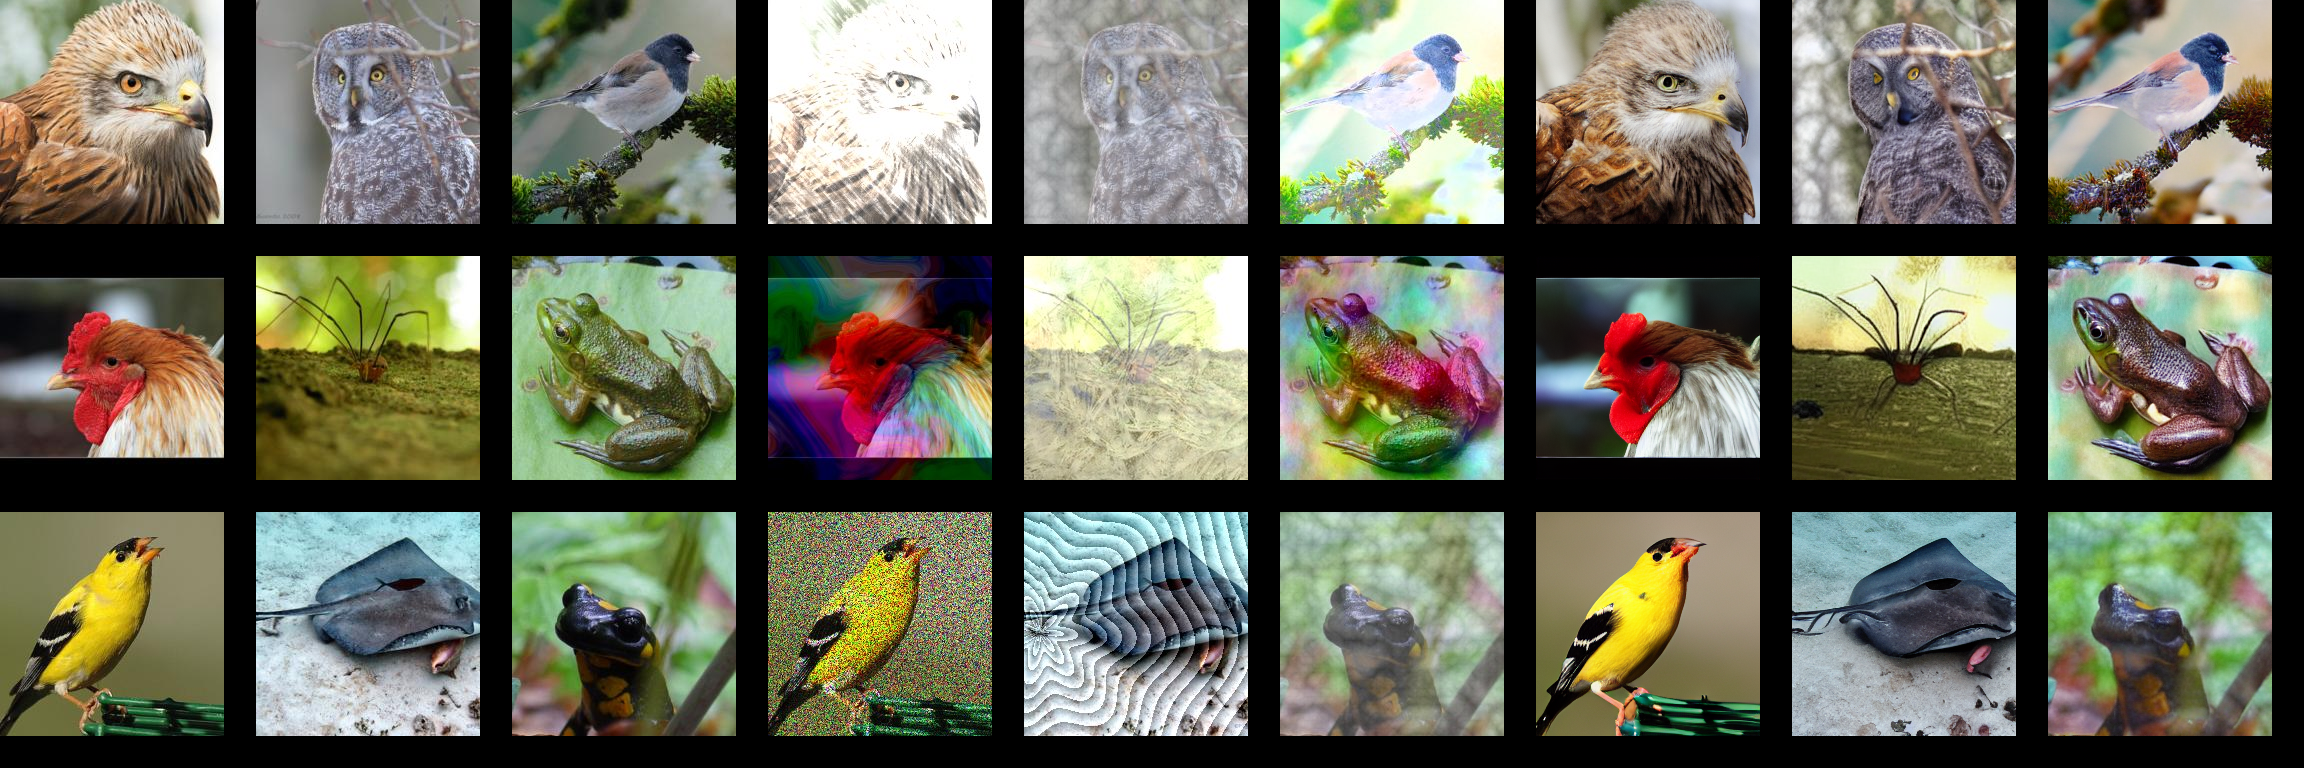

In [2]:


def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

def concat_images(images, size, shape=None, width=256, height=256):    
    # Create canvas for the final image with total size
    shape = shape if shape else (1, len(images))
    image_size = (width * shape[1], height * shape[0])
    image = Image.new('RGB', image_size)
    # Paste images into final image
    for row in range(shape[0]):
        for col in range(shape[1]):
            offset = width * col, height * row
            idx = row * shape[1] + col
            image.paste(images[idx], offset)
    
    return image

# random seed generator
generator = torch.Generator(device="cuda").manual_seed(1)
# scheduler
scheduler = DDIMScheduler(
    beta_start=0.00085, beta_end=0.012, num_train_timesteps=1000,
    beta_schedule="scaled_linear",
    clip_sample=False, set_alpha_to_one=False)
pipe.scheduler = scheduler # DDIMScheduler()


filenames_1 = natsorted(glob('./__assets__/clean_images/*'))
filenames_2 = natsorted(glob('./__assets__/corrupt_images/*'))

# if you want to edit one corrupt image, please put PIL.Image format in the pipe. 
assert len(filenames_1) == len(filenames_2)
images_1 = [Image.open(filenames_1[i]) for i in range(len(filenames_1))]
images_2 = [Image.open(filenames_2[i]) for i in range(len(filenames_2))]

# define sqrt-scheduler
guidance_scheduler = list(np.sqrt(np.linspace(1.8**2,0.0**2,20))) #+ list(np.zeros(5))
out_image = pipe(prompt=['Clean the image'] * len(filenames_2), 
            image=images_2,
            image_guidance_scale=guidance_scheduler,
            num_images_per_prompt=1,
            num_inference_steps=20, 
            generator=generator,
            num_intervention_steps=1,
            guidance_scale=7.5).images 

clean_imgs   = concat_images(images_1, (256, 256), (3, 3))
corrupt_imgs = concat_images(images_2, (256, 256), (3, 3))
recon_imgs   = concat_images(out_image, (256, 256), (3, 3))

img = get_concat_h(clean_imgs, corrupt_imgs)
get_concat_h(img, recon_imgs)
# Order : (3x3) Clean, (3x3) Corrupt, and (3x3) Edited images by Decorruptor-DPM

/data03/dsailyt/2D_generation/instruct-pix2pix-main/supple_code/deccoruptor_dpm_pipe.py:1009: FutureWarning: You have passed 9 text prompts (`prompt`), but only 1 initial images (`image`). Initial images are now duplicating to match the number of text prompts. Note that this behavior is deprecated and will be removed in a version 1.0.0. Please make sure to update your script to pass as many initial images as text prompts to suppress this warning.
  deprecate("len(prompt) != len(image)", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/20 [00:00<?, ?it/s]

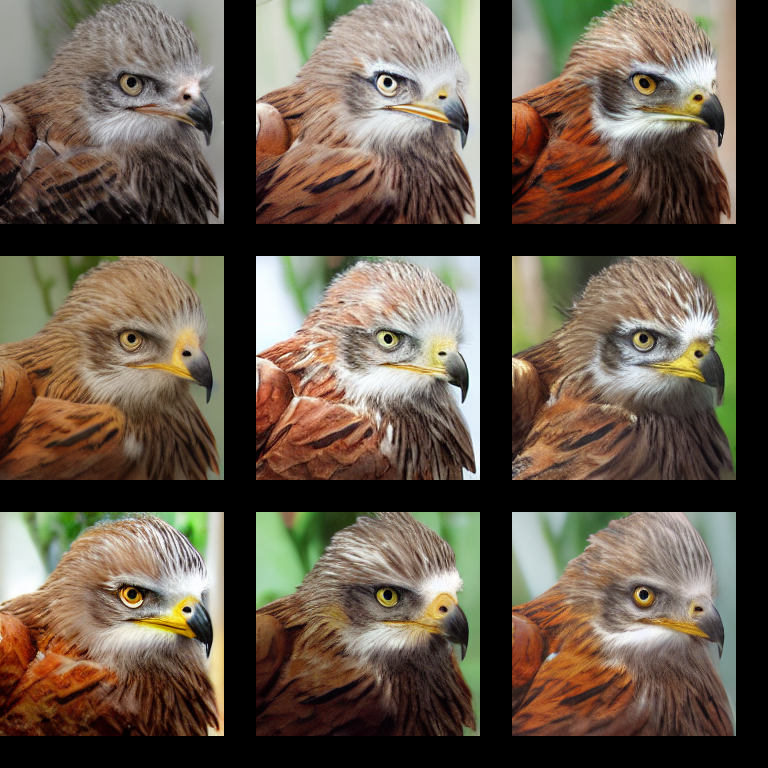

In [3]:
out_image = pipe(prompt='Clean the image', 
            image=images_2[0],
            num_images_per_prompt=9,
            image_guidance_scale=guidance_scheduler,
            num_inference_steps=20, 
            generator=generator,
            guidance_scale=7.5).images 
concat_images(out_image, (256, 256), (3, 3))